In [17]:
import json, numpy as np, pandas as pd
from collections import defaultdict, OrderedDict
from datetime import datetime

In [18]:
tasks = ("诚信数据",)
demand_states = {'任务已分发', '驳回运维意见', '待处理'}
developer_states = {'初爬通过', '正在开发', '自查完成', '正在下载源码', '正在修改', '代码完成',
                    '解析完成', '请求撤回提交', '开发完成', '源码下载完成', '疑难网站',
                    '提交任务', '初爬完成', '研发修改完成', '驳回测试修改意见', '正在解析'}
cleaning_states = {'文件清洗完成', '正在清洗', '清洗修改完成'}
test_states = {'测试查完成', '测试挂起', '正在测试', '初测通过', '返回清洗修改', '返回修改', '请清洗文件', '请重新下源码', '源码有问题'}
storage_states = {'返回修改', '入库复核通过', '入库失败', '入库完成', '正在入库', '不入库', '数据已转移', '暂不入库', '重跑一遍', '重跑完成'}
operations_states = {'网站异常', '停止维护', '全网查完成', '无增量挂起', '废弃需求', '运维发现异常', '驳回需求', '返回修改'}
abandoned_states = {'停止维护', '废弃需求'}
complete_states = {'入库完成', '数据已转移', '入库复核通过'}
def get_data(*names):
    for name in names:
        with open('%s.json' % name, 'r', encoding='utf-8') as json_file:
            yield json.loads(json_file.read())[name]
def merge_data(*args):
    res = []
    sta = []
    for data in args:
        res.extend(data)
        sta.append(len(data))
    return res, sta
def get_spider_tasks(data_list, dupefilter=()):
    spider_tasks = defaultdict(list)
    for data in data_list:
        if data['spiderName'] in dupefilter:
            continue
        spider_tasks[data['spiderName']].append(data)
    return spider_tasks
fina, stat = merge_data(*[data for data in get_data(*tasks)])
stat = dict(zip(tasks, stat))  # todo {'诚信数据': 25024}  这表示记录
spider_tasks = get_spider_tasks(fina)

In [22]:
spider_tasks_statistics = {'诚信数据': len(spider_tasks)}  # todo {'诚信数据': 836}  这表示任务量
event_state = ['需求', '开发', '测试', '清洗', '入库', '运维']
event = []
event_name_value = dict()
operation_tasks = dict()
abandoned_tasks = dict()
storage_tasks = dict()
for spiderName, spider_task in spider_tasks.items():
    _event = [0 for _ in range(6)]
    if spider_task[-1]['rwzt'] in abandoned_states:
        abandoned_tasks.setdefault(spiderName, spider_task)
    for task in spider_task:
        if spiderName not in operation_tasks and task['rwzt'] in operations_states:
            operation_tasks.setdefault(spiderName, spider_task)
        if spiderName not in storage_tasks and task['rwzt'] in complete_states:
            storage_tasks.setdefault(spiderName, spider_task)
        for index, state in enumerate(
                [demand_states, developer_states, cleaning_states, test_states, storage_states, operations_states]):
            if task['rwzt'] in state:
                _event[index] = _event[index] + 1
                break
    event.append(_event)
    event_name_value.setdefault(spiderName, _event)
events = np.array(event)  # todo [[], [], []]  各个任务的统计次数
operation_tasks_statistics = {'诚信数据': len(operation_tasks)}  # todo {'诚信数据': 644}  经历过运维的任务
abandoned_tasks_statistics = {'诚信数据': len(abandoned_tasks)}  # todo {'诚信数据': 326}  处于废弃状态的任务
storage_tasks_statistics = {'诚信数据': len(storage_tasks)}  # todo {'诚信数据': 716}  历史入库完成的爬虫
abandoned_tasks_2 = dict()
abandoned_tasks_3 = dict()
for spiderName, spider_task in storage_tasks.items():
    for task in spider_task:
        if spiderName not in abandoned_tasks_2 and task['rwzt'] in operations_states:
            abandoned_tasks_2.setdefault(spiderName, spider_task)
        if spiderName not in abandoned_tasks_3 and task['rwzt'] in abandoned_states:
            abandoned_tasks_3.setdefault(spiderName, spider_task)
storage_tasks_2_statistics = {'诚信数据': len(abandoned_tasks_2)}  # todo {'诚信数据': 546}  历史入库完成的爬虫中, 76%左右的任务会经历运维
storage_tasks_3_statistics = {'诚信数据': len(abandoned_tasks_3)}  # todo {'诚信数据': 252}  历史入库完成的爬虫中，35%左右的任务会被废弃
def get_month_statistics(tasks):
    abandoned_tasks_4 = dict()
    for spiderName, spider_task in tasks.items():
        if len(spider_task) > 1:
            time_diff = spider_task[-1]['time'] - spider_task[0]['time']
            abandoned_tasks_4.setdefault(spiderName, [time_diff//2592000, sorted(spider_task, key=lambda task: task['time'])[-1]['time']])
#     abandoned_tasks_4_keys = set(abandoned_tasks_4.keys())
#     abandoned_tasks_4_value = dict()
#     for spiderName, spider_task in event_name_value.items():
#         if spiderName in abandoned_tasks_4_keys:  # ? 这里怎么有一个废弃任务的过滤啊
#             abandoned_tasks_4_value[spiderName] = spider_task
    plot_line_x_values = []
    plot_line_y_values = []
    abandoned_tasks_4 = sorted(abandoned_tasks_4.values(), key=lambda x: x[1])
    for spider_task in abandoned_tasks_4:
        plot_line_x_values.append(spider_task[1])
        plot_line_y_values.append(spider_task[0])
#     current_year = 0
#     current_month = 0
    time_format = '%d年%d月'
    statistics = OrderedDict()
#     all_tasks = []
    for index, value in enumerate(plot_line_x_values):
        current = datetime.fromtimestamp(value)
        current_year = current.year
        current_month = current.month
        current = time_format % (current_year, current_month)
        statistics[current] = statistics.get(current, 0) + 1
    return statistics
abandoned_tasks_2_month_statistics = get_month_statistics(abandoned_tasks_2)  # 每月运维异常任务
abandoned_tasks_3_month_statistics = get_month_statistics(abandoned_tasks_3)  # 每月废弃爬虫任务
abandoned_tasks_2_month_statistics

OrderedDict([('2019年6月', 1), ('2019年7月', 3)])

In [4]:
tasks_tables = [
    ['诚信数据总记录', stat['诚信数据']],
    ['诚信数据总任务', spider_tasks_statistics['诚信数据']],
    ['有过运维记录的任务', operation_tasks_statistics['诚信数据']],
    ['处于废弃状态的任务', abandoned_tasks_statistics['诚信数据']],
    ['历史入库完成任务', storage_tasks_statistics['诚信数据']],
    ['运维(历史入库完成)', str(storage_tasks_2_statistics['诚信数据'])+'({}%)'.format(int(storage_tasks_2_statistics['诚信数据']/storage_tasks_statistics['诚信数据']*100))],
    ['废弃(历史入库完成)', str(storage_tasks_3_statistics['诚信数据'])+'({}%)'.format(int(storage_tasks_3_statistics['诚信数据']/storage_tasks_statistics['诚信数据']*100))],
]
tasks_tables_labels = ['', 'count']

In [5]:
from pandas import *
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']

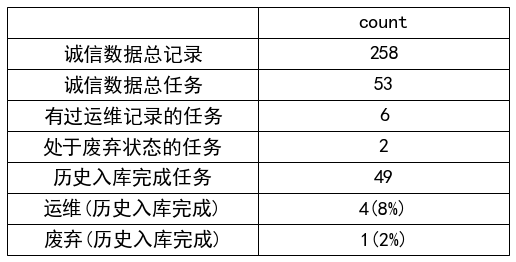

In [6]:
text_value = np.array(tasks_tables)
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
the_table=plt.table(cellText=text_value,colLabels=tasks_tables_labels,colWidths=[0.2]*text_value.shape[1],loc='center',cellLoc='center')
the_table.set_fontsize(20)
the_table.scale(2.5,2.58)
plt.show()

In [7]:
labels = abandoned_tasks_2_month_statistics.keys()
abandoned_tasks_3_month_statistics_amend = OrderedDict()
for key, value in abandoned_tasks_2_month_statistics.items():
    if key not in abandoned_tasks_3_month_statistics:
        abandoned_tasks_3_month_statistics_amend[key] = 0
    else:
        abandoned_tasks_3_month_statistics_amend[key] = abandoned_tasks_3_month_statistics[key]

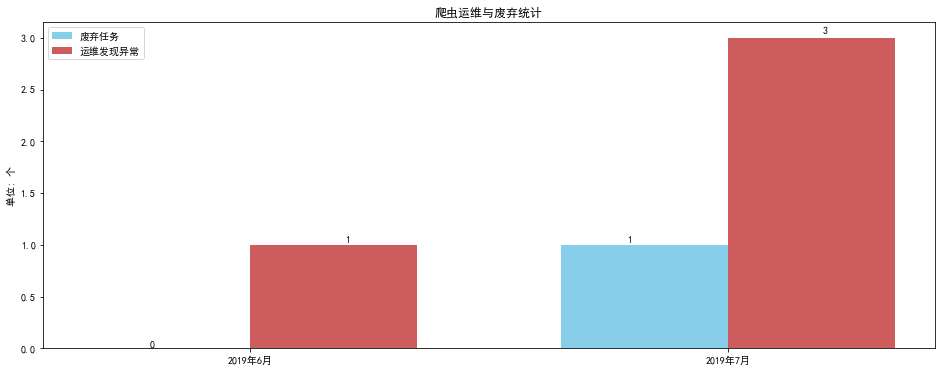

In [8]:
operations_num_list = abandoned_tasks_2_month_statistics.values()
abandoned_num_list = abandoned_tasks_3_month_statistics_amend.values()
ind = np.arange(len(operations_num_list))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, abandoned_num_list, width,
                color='SkyBlue', label='废弃任务')
rects2 = ax.bar(ind + width/2, operations_num_list, width,
                color='IndianRed', label='运维发现异常')
ax.set_ylabel('单位: 个')
ax.set_title('爬虫运维与废弃统计')
ax.set_xticks(ind)
ax.set_xticklabels(labels)
ax.legend()
def autolabel(rects, xpos='center'):
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')
autolabel(rects1, "left")
autolabel(rects2, "right")
fig.set_size_inches(16, 6)
plt.show()

In [24]:
abandoned_tasks_3_month_statistics_amend

OrderedDict([('2019年6月', 0), ('2019年7月', 1)])

In [10]:
def draw_hot_pic(vegetables, harvest):
    # matplotlib.rcParams.update({'font.size': 10)
    fig, ax = plt.subplots()
    im = ax.imshow(harvest)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(farmers)))
    ax.set_yticks(np.arange(len(vegetables)))
    ax.set_xticks(np.arange(len(farmers)+1)-.5, minor=True)
    ax.set_yticks(np.arange(len(vegetables)+1)-.5, minor=True)
    # ... and label them with the respective list entries
    ax.set_xticklabels(farmers)
    ax.set_yticklabels(vegetables)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, harvest[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("诚信数据爬虫开发流程-记录统计热度图")
    fig.tight_layout()
    fig.set_size_inches(16, 600)
    plt.show()
farmers = ['需求岗', '开发岗', '清洗岗', '测试岗', '入库岗', '运维岗']
all_vegetables = event_name_value.keys()  # 爬虫任务名
all_harvest = np.array(list(event_name_value.values()))  # 爬虫的值3
abandoned_spiderName = set(abandoned_tasks_3.keys())
abandoned_vegetables = []  # 爬虫任务名
abandoned_harvest = []  # 爬虫的值3
for spiderName, spider_task in event_name_value.items():
    if spiderName in abandoned_spiderName:
        abandoned_vegetables.append(spiderName)
        abandoned_harvest.append(spider_task)
abandoned_harvest = np.array(abandoned_harvest)

In [11]:
df = pd.DataFrame(abandoned_harvest, index=abandoned_spiderName, columns=farmers)
df.describe(percentiles=[])

,需求岗,开发岗,清洗岗,测试岗,入库岗,运维岗
count,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.0,1.0,0.0,0.0,2.0,1.0
std,NaN,NaN,NaN,NaN,NaN,NaN
min,1.0,1.0,0.0,0.0,2.0,1.0
50%,1.0,1.0,0.0,0.0,2.0,1.0
max,1.0,1.0,0.0,0.0,2.0,1.0


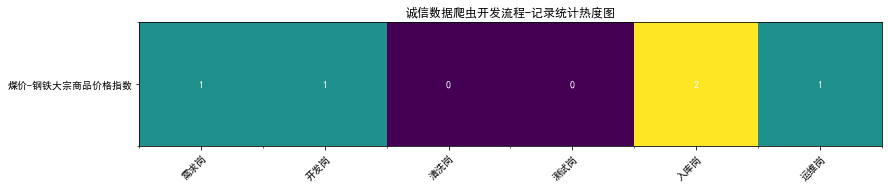

In [12]:
draw_hot_pic(abandoned_vegetables, abandoned_harvest)

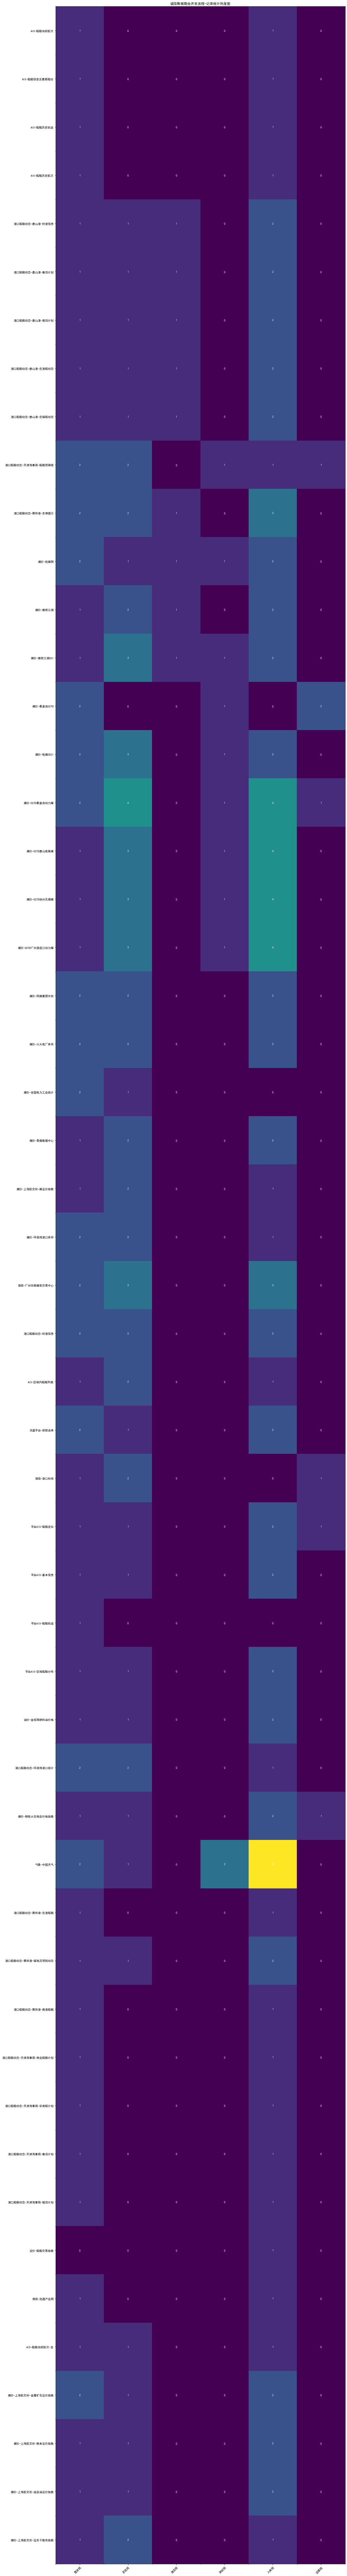

In [13]:
draw_hot_pic(all_vegetables, all_harvest)

In [14]:
"""
爬虫生命周期: 爬虫开发阶段 -> 爬虫运维阶段 -> 爬虫废弃
计算方法: 

"""
# abandoned_tasks_2

'\n爬虫生命周期: 爬虫开发阶段 -> 爬虫运维阶段 -> 爬虫废弃\n计算方法: \n\n'

In [15]:
abandoned_tasks_2

{'港口船舶动态-天津海事局-船舶预确报': [{'rwzt': '待处理',
   'id': 41887,
   'spiderName': '港口船舶动态-天津海事局-船舶预确报',
   'by': 'liulu',
   'time': 1555307217},
  {'rwzt': '待处理',
   'id': 41888,
   'spiderName': '港口船舶动态-天津海事局-船舶预确报',
   'by': 'liulu',
   'time': 1555307422},
  {'rwzt': '正在开发',
   'id': 42235,
   'spiderName': '港口船舶动态-天津海事局-船舶预确报',
   'by': '郭正霆',
   'time': 1555480439},
  {'rwzt': '开发完成',
   'id': 43419,
   'spiderName': '港口船舶动态-天津海事局-船舶预确报',
   'by': '郭正霆',
   'time': 1556525415},
  {'rwzt': '驳回需求',
   'id': 49109,
   'spiderName': '港口船舶动态-天津海事局-船舶预确报',
   'by': '郭正霆',
   'time': 1561960981},
  {'rwzt': '返回修改',
   'id': 49126,
   'spiderName': '港口船舶动态-天津海事局-船舶预确报',
   'by': 'liulu',
   'time': 1561964704},
  {'rwzt': '入库完成',
   'id': 49155,
   'spiderName': '港口船舶动态-天津海事局-船舶预确报',
   'by': '郭正霆',
   'time': 1561972549}],
 '煤价-CCTD秦皇岛动力煤': [{'rwzt': '待处理',
   'id': 42240,
   'spiderName': '煤价-CCTD秦皇岛动力煤',
   'by': 'liulu',
   'time': 1555483142},
  {'rwzt': '待处理',
   'id': 42244,
   'spiderName